# import

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np 
from sklearn import datasets
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from ray import tune
from ray.tune import CLIReporter
from ray.tune.schedulers import ASHAScheduler

# data

In [75]:
data_path = (r'..\data\data_ready.csv')

In [76]:
data = pd.read_csv(data_path,index_col=0)

In [77]:
data.isnull().sum()

Ost_8010_208            0
DonBosco_8020_110       0
DonBosco_8020_119       0
DonBosco_8020_122       0
DonBosco_8053_111       0
                       ..
S_NO                    0
Sud_peek_wind_speed     0
W_NO                    0
W_NOX                   0
West_peek_wind_speed    0
Length: 96, dtype: int64

# funckcija za podatke 

In [78]:
def data_sites(site,pollutant):
    df = data.copy()
    df1 = df.filter(like=site, axis=1)
    df2 = df[[pollutant]]
    df3 = df[['Cloud_Cover_Mean','Temperature_Air_2m_Max_Day_Time', 'Temperature_Air_2m_Min_Night_Time','Wind_Speed_10m_Mean']]
    df4 = df[['year', 'dayofyear', 'month_Apr', 'month_Aug', 'month_Dec',
       'month_Feb', 'month_Jan', 'month_Jul', 'month_Jun', 'month_Mar',
       'month_May', 'month_Nov', 'month_Oct', 'month_Sep', 'weekday_Friday',
       'weekday_Monday', 'weekday_Saturday', 'weekday_Sunday',
       'weekday_Thursday', 'weekday_Tuesday', 'weekday_Wednesday',
       'season_fall', 'season_spring', 'season_summer', 'season_winter', 'holiday', 'holiday_school']]
    d = pd.concat([df1,df2,df3,df4],axis=1)
    return d

# podaci za Nord, N_NO2

In [79]:
data_model = data_sites('Nord','N_NO2')

In [80]:
X = data_model.drop('N_NO2',axis=1)
Y = data_model[['N_NO2']]

In [81]:
X_train = X.loc[:'2020-01-02']
X_test = X.loc['2020-01-03':'2020-03-10']
y_train = Y.loc[:'2020-01-02'].values.reshape((-1, 1))
y_test = Y.loc['2020-01-03':'2020-03-10'].values.reshape((-1, 1))

In [82]:
sc = MinMaxScaler()

X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [83]:
X_train_t = torch.FloatTensor(X_train)
Y_train_t = torch.FloatTensor(y_train).reshape(-1,1) 

In [84]:
X_test_t = torch.FloatTensor(X_test)

In [101]:
# Define network dimensions
input_size = X_train.shape[1]
# Layer size
hidden_size = 1000 # Number of hidden nodes
output_size = 1 # Number of output nodes for prediction

# Build mdel
torch_model = torch.nn.Sequential(torch.nn.Linear(input_size, hidden_size),
                                  torch.nn.ReLU(),
                                  torch.nn.Linear(hidden_size, output_size))    
print(torch_model)

Sequential(
  (0): Linear(in_features=43, out_features=1000, bias=True)
  (1): ReLU()
  (2): Linear(in_features=1000, out_features=1, bias=True)
)


In [102]:
loss_func = torch.nn.MSELoss() #mean square error as loss metric
learning_rate = 0.001
optimizer = torch.optim.Adam(torch_model.parameters(), lr=learning_rate)

Text(0.5, 1.0, 'Training Loss')

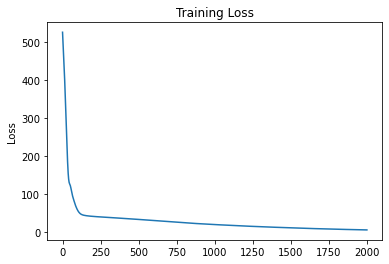

In [103]:
train_error = []
epochs = 2000

#Y_train_t = torch.FloatTensor(y_train).reshape(-1,1) #Converting numpy array to torch tensor

for e in range(epochs):
    #X_train_t = torch.FloatTensor(xtrain)  #Converting numpy array to torch tensor
    
    y_pred = torch_model(X_train_t)
    loss = loss_func(y_pred, Y_train_t)
    loss.backward()
    optimizer.step()
    
    optimizer.zero_grad()

    train_error.append(loss.item())

plt.plot(train_error)
plt.ylabel('Loss')
plt.title('Training Loss')

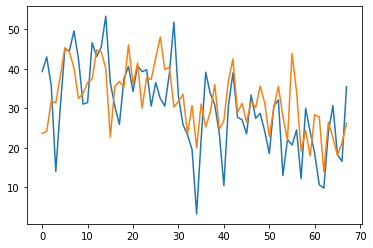

In [104]:
ypredict = torch_model(X_test_t)
# Descale
ypredict_np = ypredict.detach().numpy()
#ypredict_inverse = scaler_y.inverse_transform(ypredict_np)
#ytest_inverse = scaler_y.inverse_transform(ytest)

plt.plot(y_test)#_inverse)
plt.legend
plt.plot(ypredict_np)#_inverse)

In [105]:
print('MSE:', mean_squared_error(y_test, ypredict_np, squared=True))
print(r2_score(y_test, ypredict_np))


MSE: 83.07943863492908
0.2792148227927186
